In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18913 sha256=17b86d45ab904629bc20b8dd7d3d89b0d627be8730a867692da2a20d305c556b
  Stored in directory: /root/.cache/pip/wheels/ac/13/2d/3de7c76f618a8d162884ac5b726a8c2242ad88afa370f1e62f
Successfully built keras-self-attention


In [84]:
#importing libraries 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from glob import glob
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from keras.layers import Input, Dense, LeakyReLU, Dropout, Conv1D, MaxPool1D, Flatten, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention


In [4]:
Dirpath= "/content/drive/MyDrive/ECG_classification/Files/"

In [5]:
alldata = np.empty(shape=[0, 188])
print(alldata.shape)
paths = glob(Dirpath+'data_ecg_new/*'+'.csv')
for path in paths:
    try:
     csvrows = np.loadtxt(path, delimiter=',')
     alldata = np.append(alldata, csvrows, axis=0)
    except:
      continue

(0, 188)


In [6]:
data_df=pd.DataFrame(alldata)
classes_num=data_df[187].value_counts()
print(classes_num)

1.0    112447
6.0      9722
3.0      9585
2.0      6566
7.0      4783
5.0      3131
4.0       820
Name: 187, dtype: int64


In [7]:
# Create an empty dataframe to store the samples as unseen data
samples_df = pd.DataFrame()

# Extract 100 random samples from each class and concatenate them together
for i in range(1, 8):
    class_df = data_df[data_df.iloc[:,-1] == i].sample(100) # select 100 random samples from the class
    samples_df = pd.concat([samples_df, class_df]) # concatenate the samples to the samples dataframe

data_df_new = data_df.copy()
data_df_new.drop(samples_df.index, inplace=True) #taking remaining samples for further processing

In [8]:
classes_num=data_df_new.iloc[:,-1].value_counts()
print(classes_num)

1.0    112347
6.0      9622
3.0      9485
2.0      6466
7.0      4683
5.0      3031
4.0       720
Name: 187, dtype: int64


In [63]:
# Create the generator model
input_layer = Input(shape=(187,1))
hidden_layer = Conv1D(32, kernel_size=3, padding="same", activation='relu')(input_layer)
hidden_layer = MaxPool1D(pool_size=2)(hidden_layer)
hidden_layer = Conv1D(64, kernel_size=3, padding="same", activation='relu')(hidden_layer)
hidden_layer = MaxPool1D(pool_size=2)(hidden_layer)
hidden_layer = Flatten()(hidden_layer)
hidden_layer = Dense(200)(hidden_layer)
hidden_layer = LeakyReLU()(hidden_layer)
output_layer = Dense(187, activation='tanh')(hidden_layer)
generator = Model(input_layer, output_layer)

#Create the discriminator model

input_layer = Input(shape=(187,1))
hidden_layer = Conv1D(64, kernel_size=3, padding="same", activation='relu')(input_layer)
hidden_layer = MaxPool1D(pool_size=2)(hidden_layer)
hidden_layer = Conv1D(32, kernel_size=3, padding="same", activation='relu')(hidden_layer)
hidden_layer = MaxPool1D(pool_size=2)(hidden_layer)
hidden_layer = Flatten()(hidden_layer)
hidden_layer = Dense(200)(hidden_layer)
hidden_layer = LeakyReLU()(hidden_layer)
output_layer = Dense(1, activation='sigmoid')(hidden_layer)
discriminator = Model(input_layer, output_layer)

#Compile the models
adam = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False
gan_input = Input(shape=(187,1))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer=adam, loss='binary_crossentropy')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [64]:
# Extracting batch from minority class

X=data_df_new.iloc[:,:-1]
def get_batch(X, y, minority_class, batch_size):
    X_minority = X[y==minority_class]
    y_minority = y[y==minority_class]
    sample_indices = np.random.randint(0, X_minority.shape[0], size=batch_size)
    return X_minority.iloc[sample_indices], y_minority.iloc[sample_indices]

In [65]:
#training GAN architecture 

batch_size=5
X=data_df_new.iloc[:,:-1]

# Train the GAN
for i in range(100):
    # Get a batch of real samples
    X_real, y_real = get_batch(data_df_new.iloc[:,:-1], data_df_new.iloc[:,-1],4, 5)
    
    # Generate a batch of fake samples
    noise = np.random.normal(0,1, (batch_size, X.shape[1]))
    X_fake = generator.predict(noise)
    
    # Train the discriminator
    X_batch = np.concatenate([X_real, X_fake])
    y_batch = np.concatenate([np.ones(batch_size), np.zeros(batch_size)])
    d_loss = discriminator.train_on_batch(X_batch, y_batch)
    
    # Generate new random noise
    noise = np.random.normal(0,1, (batch_size, X.shape[1]))
    
    # Train the generator
    g_loss = gan.train_on_batch(noise, np.ones(batch_size))
    
    # Print the losses
    print("iteration %d: d_loss = %.3f, g_loss = %.3f" % (i+1, d_loss[0], g_loss))

1/1 [==============================] - 0s 73ms/step
iteration 1: d_loss = 0.683, g_loss = 0.716
1/1 [==============================] - 0s 14ms/step
iteration 2: d_loss = 0.678, g_loss = 0.703
1/1 [==============================] - 0s 14ms/step
iteration 3: d_loss = 0.680, g_loss = 0.703
1/1 [==============================] - 0s 13ms/step
iteration 4: d_loss = 0.669, g_loss = 0.708
1/1 [==============================] - 0s 16ms/step
iteration 5: d_loss = 0.671, g_loss = 0.721
1/1 [==============================] - 0s 14ms/step
iteration 6: d_loss = 0.640, g_loss = 0.752
1/1 [==============================] - 0s 14ms/step
iteration 7: d_loss = 0.631, g_loss = 0.787
1/1 [==============================] - 0s 15ms/step
iteration 8: d_loss = 0.609, g_loss = 0.824
1/1 [==============================] - 0s 14ms/step
iteration 9: d_loss = 0.584, g_loss = 0.842
1/1 [==============================] - 0s 13ms/step
iteration 10: d_loss = 0.587, g_loss = 0.845
1/1 [==============================] - 

In [66]:
#Samples generation

num_samples = 3000
noise = np.random.rand(num_samples, 187)
generated_samples = generator.predict(noise)

94/94 [==============================] - 0s 1ms/step


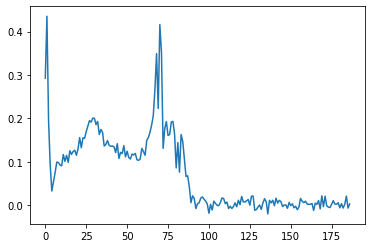

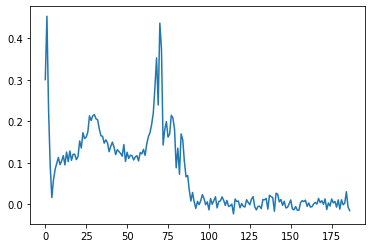

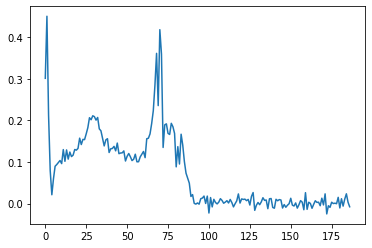

([<matplotlib.lines.Line2D at 0x7f0bfa045610>], None)

In [67]:
#checking generated samples

plt.plot(generated_samples[4]), plt.show()
plt.plot(generated_samples[200]), plt.show()
plt.plot(generated_samples[1000]),plt.show()

In [68]:
generated_samples = np.c_[generated_samples, np.full((generated_samples.shape[0], 1), 4)]

In [69]:
generated_samples=pd.DataFrame(generated_samples)
generated_samples.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.311162,0.452054,0.221455,0.092591,0.018667,0.065521,0.071375,0.103761,0.113182,0.097004,...,0.000872,0.017784,-0.004318,0.010021,-0.002529,-0.003499,0.014083,0.001477,-0.000768,4.0
1,0.308940,0.450786,0.212318,0.085869,0.027291,0.054840,0.096791,0.102204,0.103556,0.096537,...,-0.006465,0.013443,-0.017664,-0.004823,-0.015119,0.006594,0.021300,-0.008724,-0.009436,4.0
2,0.292599,0.439128,0.213875,0.082780,0.020965,0.060126,0.083540,0.089533,0.097870,0.095452,...,0.004635,0.021999,-0.017777,0.019734,-0.011556,0.010879,0.030124,-0.008678,-0.002227,4.0
3,0.302835,0.466026,0.221587,0.086322,0.022745,0.056543,0.083048,0.099021,0.117046,0.095773,...,0.001658,0.011726,-0.016926,0.011320,-0.011733,0.014432,0.037664,-0.005831,-0.001567,4.0
4,0.292642,0.435297,0.194967,0.091814,0.032545,0.053747,0.074976,0.099145,0.098228,0.092485,...,0.002138,0.005549,-0.006136,0.003310,-0.006749,0.001888,0.020777,-0.006867,0.002839,4.0


In [70]:
data_df_new2 = pd.concat([data_df_new, generated_samples])

In [71]:
classes_num=data_df_new2.iloc[:,-1].value_counts()
print(classes_num)

1.0    112347
6.0      9622
3.0      9485
2.0      6466
7.0      4683
4.0      3720
5.0      3031
Name: 187, dtype: int64


In [72]:
X=data_df_new2.iloc[:,:-1]
Y=data_df_new2.iloc[:,-1]

In [73]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import numpy as np


# Get the count of samples for each class
counts = dict(Counter(Y))

# Define the number of samples you want for each class
n_samples = min(counts.values())

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy={class_: n_samples for class_ in counts.keys()}, random_state=42)

# Apply the under-sampling
X_resampled, y_resampled = rus.fit_resample(X, Y)

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_resampled, y_resampled, test_size=0.2)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2)

In [75]:
X_train.shape, Y_train.shape

((13578, 187), (13578,))

In [76]:
X_train=X_train.values
X_val=X_val.values
X_test=X_test.values

In [77]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test=X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [78]:
from keras.utils import to_categorical
Y_train_cat=to_categorical(Y_train)
Y_val_cat=to_categorical(Y_val)

In [79]:
X_train.shape, Y_train_cat.shape

((13578, 187, 1), (13578, 8))

In [180]:
from keras.layers import Input, Convolution1D, BatchNormalization, MaxPool1D, Flatten, Dense
from keras.models import Model
from keras.utils import to_categorical

In [181]:
im_shape=(X_train.shape[1],1)
print(im_shape)

(187, 1)


In [182]:
def create_cnn_model_1(inputs_shape):
    inputs_cnn = Input(shape=inputs_shape, name='inputs_cnn')
    conv1 = Convolution1D(64, (9), activation='relu', input_shape=inputs_shape)(inputs_cnn)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1)
    conv2 = Convolution1D(64, (6), activation='relu', input_shape=inputs_shape)(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2)
    conv3 = Convolution1D(64, (3), activation='relu', input_shape=inputs_shape)(pool2)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3)

    attention = SeqSelfAttention(attention_activation='sigmoid')(pool3)

    flatten = Flatten()(pool3)

    dense1 = Dense(64, activation='relu')(flatten)
    dense2 = Dense(32, activation='relu')(dense1)
    main_output = Dense(8, activation='softmax', name='main_output')(dense2)

    model = Model(inputs=inputs_cnn, outputs=main_output)
    return model

In [183]:
def create_cnn_model_2(inputs_shape):
    inputs_cnn1 = Input(shape=inputs_shape, name='inputs_cnn1')
    inputs_cnn2 = Input(shape=inputs_shape, name='inputs_cnn2')

    # Branch 1
    conv1 = Conv1D(32, (9), activation='relu', input_shape=inputs_shape)(inputs_cnn1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1)
    conv2 = Conv1D(32, (6), activation='relu')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2)
    conv3 = Conv1D(16, (3), activation='relu')(pool2)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3)

    # Branch 2
    conv1_2 = Conv1D(32, (9), activation='selu', input_shape=inputs_shape)(inputs_cnn2)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_2 = MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_2)
    conv2_2 = Conv1D(32, (6), activation='selu')(pool1_2)
    conv2_2 = BatchNormalization()(conv2_2)
    pool2_2 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_2)
    conv3_2 = Conv1D(16, (3), activation='selu')(pool2_2)
    conv3_2 = BatchNormalization()(conv3_2)
    pool3_2 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_2)

    # Concatenate the outputs from both branches
    concatenated = concatenate([pool3, pool3_2])

    attention = SeqSelfAttention(attention_activation='sigmoid')(concatenated)

    flatten = Flatten()(concatenated)

    dense1 = Dense(64, activation='relu')(flatten)
    dense2 = Dense(32, activation='relu')(dense1)
    main_output = Dense(8, activation='softmax', name='main_output')(dense2)

    model = Model(inputs=[inputs_cnn1, inputs_cnn2],  outputs=main_output)
    return model


In [184]:
model_1=create_cnn_model_1(im_shape)

In [185]:
model_2=create_cnn_model_2(im_shape)

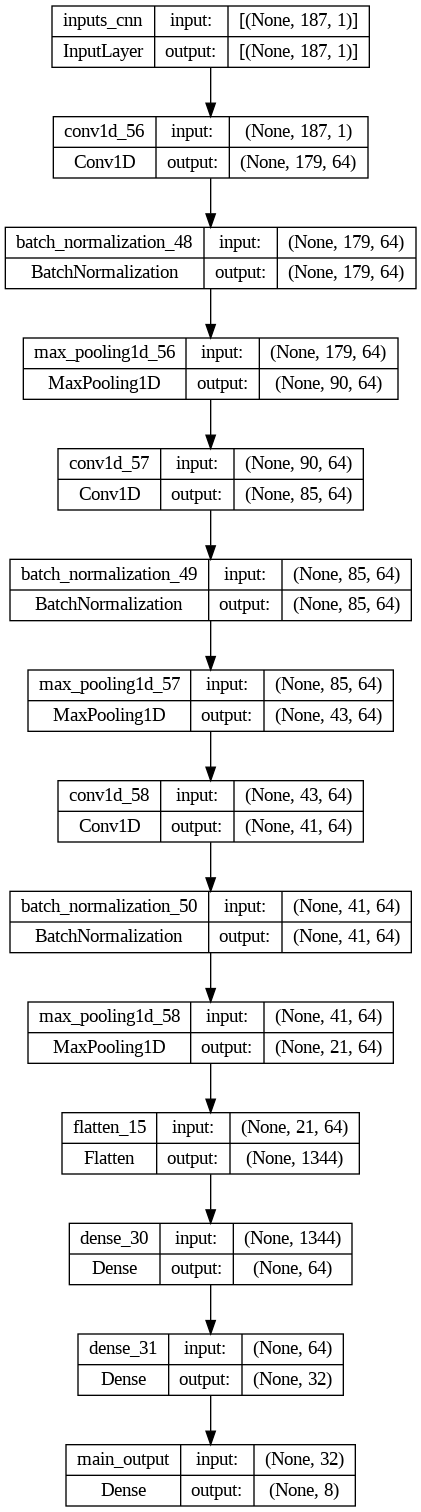

In [186]:
from IPython.display import Image
from keras.utils import plot_model
plot_model(model_1, show_shapes=True, show_layer_names=True)

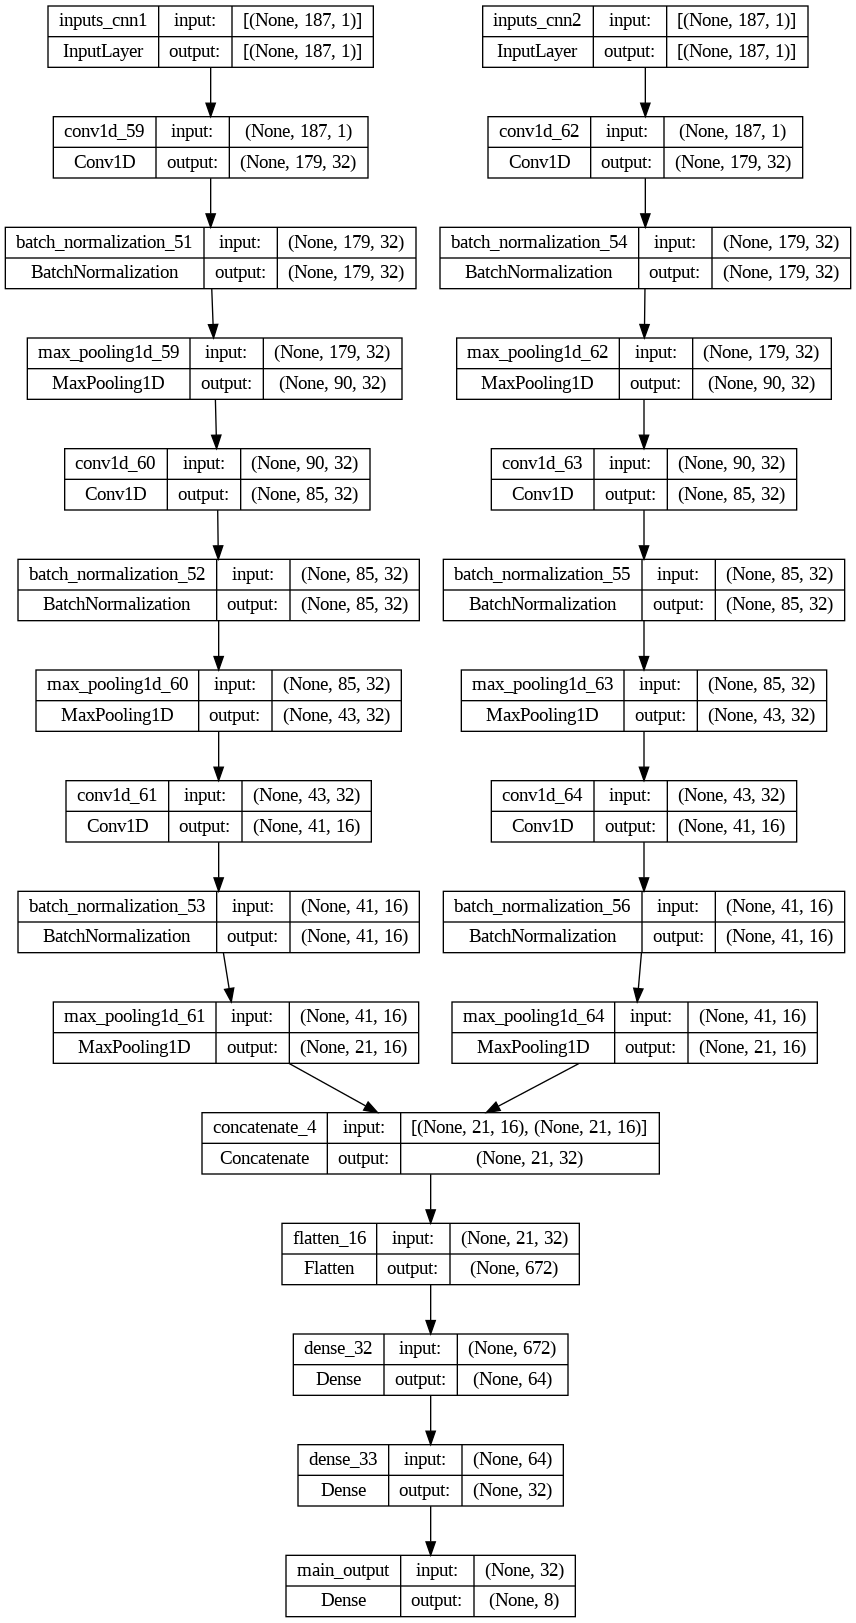

In [187]:
plot_model(model_2, show_shapes=True, show_layer_names=True)

In [188]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
history=model_1.fit(X_train, Y_train_cat,epochs=20, batch_size=32,validation_data=(X_val,Y_val_cat), verbose=2)

Epoch 1/20
425/425 - 4s - loss: 0.3704 - accuracy: 0.8761 - val_loss: 0.9763 - val_accuracy: 0.6654 - 4s/epoch - 9ms/step
Epoch 2/20
425/425 - 2s - loss: 0.1870 - accuracy: 0.9388 - val_loss: 0.2534 - val_accuracy: 0.9206 - 2s/epoch - 6ms/step
Epoch 3/20
425/425 - 2s - loss: 0.1380 - accuracy: 0.9537 - val_loss: 0.1618 - val_accuracy: 0.9479 - 2s/epoch - 6ms/step
Epoch 4/20
425/425 - 2s - loss: 0.1151 - accuracy: 0.9595 - val_loss: 0.1677 - val_accuracy: 0.9456 - 2s/epoch - 6ms/step
Epoch 5/20
425/425 - 2s - loss: 0.0983 - accuracy: 0.9665 - val_loss: 0.1317 - val_accuracy: 0.9585 - 2s/epoch - 6ms/step
Epoch 6/20
425/425 - 2s - loss: 0.0756 - accuracy: 0.9749 - val_loss: 0.1195 - val_accuracy: 0.9637 - 2s/epoch - 6ms/step
Epoch 7/20
425/425 - 2s - loss: 0.0704 - accuracy: 0.9744 - val_loss: 0.1365 - val_accuracy: 0.9576 - 2s/epoch - 6ms/step
Epoch 8/20
425/425 - 2s - loss: 0.0670 - accuracy: 0.9761 - val_loss: 0.2898 - val_accuracy: 0.9260 - 2s/epoch - 6ms/step
Epoch 9/20
425/425 - 2s 

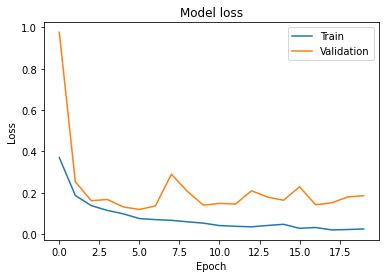

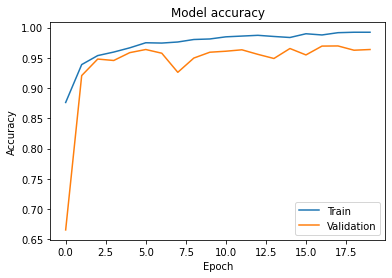

In [189]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [190]:
Y_pred = model.predict(X_test)
Y_pred=Y_pred.argmax(axis=-1)
print(Y_pred[0])

107/107 [==============================] - 0s 2ms/step
6


In [191]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(Y_test, Y_pred))

Accuracy: 0.9493372606774668


In [192]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


              precision    recall  f1-score   support

         1.0       0.89      0.91      0.90       507
         2.0       0.93      0.99      0.96       475
         3.0       0.99      0.96      0.98       474
         4.0       0.98      0.95      0.97       482
         5.0       0.94      0.94      0.94       501
         6.0       0.97      1.00      0.98       478
         7.0       0.95      0.90      0.92       478

    accuracy                           0.95      3395
   macro avg       0.95      0.95      0.95      3395
weighted avg       0.95      0.95      0.95      3395



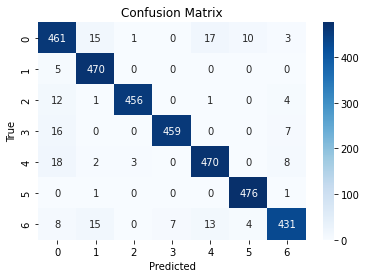

In [193]:
conf_mat = confusion_matrix(Y_test, Y_pred)
print(classification_report(Y_test, Y_pred))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [194]:
X_unseen=samples_df.iloc[:,:-1]
Y_unseen=samples_df.iloc[:,-1]

In [195]:
Y_pred = model_1.predict(X_unseen)
Y_pred=Y_pred.argmax(axis=-1)
print(Y_pred[0])

22/22 [==============================] - 0s 2ms/step
1


In [196]:
print("Accuracy:", accuracy_score(Y_unseen, Y_pred))

Accuracy: 0.8985714285714286


              precision    recall  f1-score   support

         1.0       0.83      0.91      0.87       100
         2.0       0.99      1.00      1.00       100
         3.0       0.99      0.98      0.98       100
         4.0       1.00      0.52      0.68       100
         5.0       0.93      0.92      0.92       100
         6.0       1.00      0.98      0.99       100
         7.0       0.69      0.98      0.81       100

    accuracy                           0.90       700
   macro avg       0.92      0.90      0.89       700
weighted avg       0.92      0.90      0.89       700



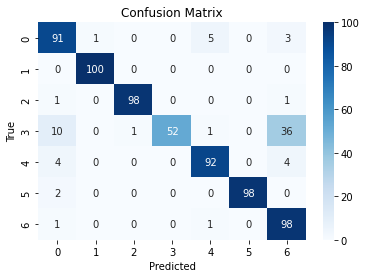

In [199]:
conf_mat = confusion_matrix(Y_unseen, Y_pred)
print(classification_report(Y_unseen, Y_pred))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [198]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
history=model_2.fit([X_train, X_train], Y_train_cat,epochs=20, batch_size=32,validation_data=([X_val, X_val],Y_val_cat), verbose=2)

Epoch 1/20
425/425 - 5s - loss: 0.4098 - accuracy: 0.8657 - val_loss: 0.8337 - val_accuracy: 0.6616 - 5s/epoch - 12ms/step
Epoch 2/20
425/425 - 3s - loss: 0.1942 - accuracy: 0.9384 - val_loss: 0.2313 - val_accuracy: 0.9295 - 3s/epoch - 7ms/step
Epoch 3/20
425/425 - 3s - loss: 0.1485 - accuracy: 0.9526 - val_loss: 0.1734 - val_accuracy: 0.9392 - 3s/epoch - 8ms/step
Epoch 4/20
425/425 - 3s - loss: 0.1223 - accuracy: 0.9607 - val_loss: 0.1649 - val_accuracy: 0.9486 - 3s/epoch - 8ms/step
Epoch 5/20
425/425 - 3s - loss: 0.1023 - accuracy: 0.9656 - val_loss: 0.1723 - val_accuracy: 0.9477 - 3s/epoch - 7ms/step
Epoch 6/20
425/425 - 3s - loss: 0.0924 - accuracy: 0.9683 - val_loss: 0.1668 - val_accuracy: 0.9536 - 3s/epoch - 8ms/step
Epoch 7/20
425/425 - 3s - loss: 0.0826 - accuracy: 0.9700 - val_loss: 0.1475 - val_accuracy: 0.9566 - 3s/epoch - 7ms/step
Epoch 8/20
425/425 - 3s - loss: 0.0716 - accuracy: 0.9745 - val_loss: 0.1403 - val_accuracy: 0.9602 - 3s/epoch - 7ms/step
Epoch 9/20
425/425 - 3s

In [200]:
Y_pred = model_2.predict([X_unseen, X_unseen])
Y_pred=Y_pred.argmax(axis=-1)
print(Y_pred[0])

22/22 [==============================] - 0s 3ms/step
1


In [201]:
print("Accuracy:", accuracy_score(Y_unseen, Y_pred))

Accuracy: 0.9442857142857143


              precision    recall  f1-score   support

         1.0       0.85      0.92      0.88       100
         2.0       1.00      0.99      0.99       100
         3.0       0.96      0.99      0.98       100
         4.0       0.97      0.84      0.90       100
         5.0       0.92      0.95      0.94       100
         6.0       1.00      0.97      0.98       100
         7.0       0.92      0.95      0.94       100

    accuracy                           0.94       700
   macro avg       0.95      0.94      0.94       700
weighted avg       0.95      0.94      0.94       700



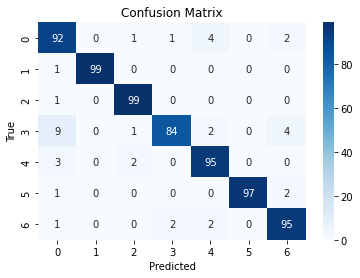

In [202]:
conf_mat = confusion_matrix(Y_unseen, Y_pred)
print(classification_report(Y_unseen, Y_pred))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()